In [1]:
data_path = '/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe2'
data_file = '/data/B1/data.mat'
epoch_file = '/data/B1/preprocessing/B1_EEG_epo.fif'

relevant_electrodes = ['O2','PO4','PO8','P8','P4','P6','P2','P1','P3','P5','P7','PO7','PO3','O1','Pz','POz','Oz','Iz']

# Dic to index trial_info matrix
info_colnames = {'reaction_times':0,'reaction_err':1, 'answer':2,'base_delay':3,\
                      'target_timings':4, 'flicker_sides':5, 'cued_side':6, 'orients_L':7, 'orients_R':8,\
                      'angle_magnitude':9, 'probe_sides':10, 'targets_binary':12, 'attention_type_block':13,\
                      'trial_num_my_rec':14}
info_colnumtonames = {v: k for k, v in info_colnames.items()}




In [2]:
import scipy.io as sio
import scipy
import numpy as np
import pandas as pd
import mne
from mne.time_frequency import EpochsTFRArray
import matplotlib.pyplot as plt
import copy
from collections import Counter
from frequency_tagging_funs import snr_spectrum, frequency_rescaling


In [3]:
f = sio.loadmat(f'{data_path}{data_file}')

# Create pd df to pass to mne metadata
pd_info = {}
for i, column in enumerate(f['data'][0][0]):
    if i in info_colnames.values():
        # Remove practice trials
        column = column[4:,:]
        # Collapse to trial indexes
        original_shape = column.shape
        new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
        column = np.reshape(column, new_shape)
        pd_info[info_colnumtonames[i]] = column
pd_info = pd.DataFrame(pd_info, columns=info_colnames.keys())
pd_info 

# Load eeg epochs .fif and add metadata
epochs = mne.read_epochs(f'{data_path}{epoch_file}')
epoch_good = [x for x,y in enumerate(epochs.drop_log) if len(y) == 0]
epochs.metadata = pd_info.iloc[epoch_good]

Reading /home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe2/data/B1/preprocessing/B1_EEG_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
573 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 14 columns


In [4]:
contingency_table = pd.crosstab(pd_info['flicker_sides'], pd_info['cued_side'])

print("Contingency Table:")
print(contingency_table)

Contingency Table:
cued_side        0    1
flicker_sides          
0              144  144
1              144  144


In [5]:
# Keep only posterior electrodes
epochs.pick_channels(relevant_electrodes)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Number of events,573
Events,3: 573
Time range,-1.000 – 2.000 s
Baseline,-1.000 – 0.000 s


In [6]:
# Keep only trials where there was no target
epochs = epochs['targets_binary==1']

# A. Endogeneous condition
## 1 FFT & SNR

In [7]:


# Simplify metadata
epochs.metadata['flicker_sides'] = epochs.metadata['flicker_sides'].replace({0: 6064, 1: 6460})
epochs.metadata['cued_side'] = epochs.metadata['cued_side'].replace({0: 'left', 1: 'right'})

condition_1 = ((epochs.metadata['flicker_sides'] == 6064.0) & (epochs.metadata['cued_side'] == 'left')) | \
    ((epochs.metadata['flicker_sides'] == 6460.0) & (epochs.metadata['cued_side'] == 'right'))
condition_2 = ((epochs.metadata['flicker_sides'] == 6064.0) & (epochs.metadata['cued_side'] == 'right')) | \
    ((epochs.metadata['flicker_sides'] == 6460.0) & (epochs.metadata['cued_side'] == 'left'))
epochs.metadata['cued_tag'] = np.where(condition_1, 60, np.where(condition_2, 64, np.nan))
epochs_endo = epochs['attention_type_block==1'].copy()
epochs_exo = epochs['attention_type_block==0'].copy()

/tmp/ipykernel_40601/4082944448.py:102: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


SNR at 60Hz in endogenous condition: 6.051670154613237
SNR at 64Hz in endogenous: 3.867377111947706
SNR at 60Hz in exogenous condition: 4.769197512156687
SNR at 64Hz in exogenous: 4.582762844243671


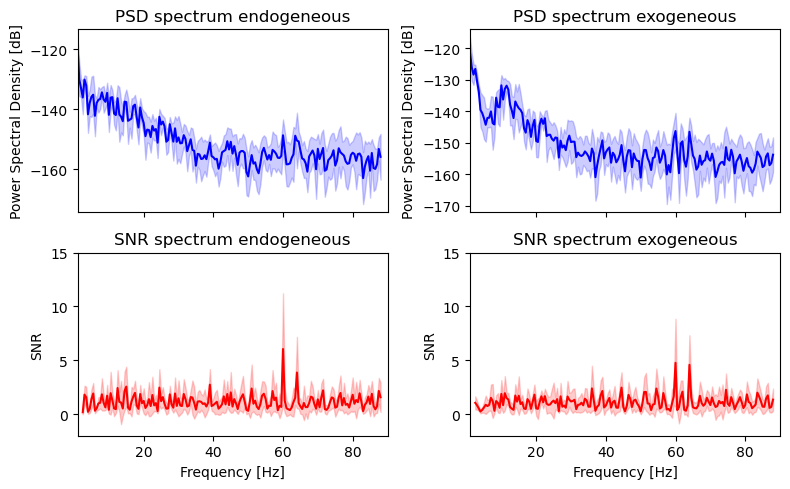

In [8]:
# Fast Fourier Transform
# adapted from https://mne.tools/dev/auto_tutorials/time-freq/50_ssvep.html

sfreq = epochs.info["sfreq"]
tmin = 0 # Search in window starting from cue (when SSVEP is expected)
tmax = 2
fmin = 1.0
fmax = 90

# Spectrum of the signal averaged over trials
spectrum_endo = epochs_endo.copy().average().compute_psd(
    "welch",
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0,
    n_per_seg=None,
    tmin=tmin,
    tmax=tmax,
    fmin=fmin,
    fmax=fmax,
    window="hamming",
    verbose=False,
)
psds_endo, freqs_psd = spectrum_endo.get_data(return_freqs=True)
spectrum_exo = epochs_exo.copy().average().compute_psd(
    "welch",
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0,
    n_per_seg=None,
    tmin=tmin,
    tmax=tmax,
    fmin=fmin,
    fmax=fmax,
    window="hamming",
    verbose=False,
)
psds_exo, freqs_psd = spectrum_exo.get_data(return_freqs=True)


# Get bins to exlude from regularization (close neighbors ±0.5Hz)  
bin_size = np.diff(freqs_psd)[0]
skip_nei = int((0.5 - bin_size/2)//bin_size) 

# Get bins to include in regularization (neighbors within +/- 2-0.5Hz)
used_nei = int((2 - bin_size/2) // bin_size)  # Total bins within ±2 Hz
used_nei = used_nei - skip_nei # Bins within (0.5 Hz, 2 Hz]

snrs_endo = snr_spectrum(psds_endo, noise_n_neighbor_freqs=used_nei, noise_skip_neighbor_freqs = skip_nei)
snrs_exo = snr_spectrum(psds_exo, noise_n_neighbor_freqs=used_nei, noise_skip_neighbor_freqs = skip_nei)

fig, axes = plt.subplots(2, 2, sharex="all", sharey="none", figsize=(8, 5))
freq_range = range(
    np.where(np.floor(freqs_psd) == 1.0)[0][0], np.where(np.ceil(freqs_psd) == fmax - 1)[0][0]
)

psds_plot = 10 * np.log10(psds_endo)
psds_mean = psds_plot.mean(axis=(0))[freq_range]
psds_std = psds_plot.std(axis=(0))[freq_range]
axes[0,0].plot(freqs_psd[freq_range], psds_mean, color="b")
axes[0,0].fill_between(
    freqs_psd[freq_range], psds_mean - psds_std, psds_mean + psds_std, color="b", alpha=0.2
)
axes[0,0].set(title="PSD spectrum endogeneous", ylabel="Power Spectral Density [dB]")
psds_plot = 10 * np.log10(psds_exo)
psds_mean = psds_plot.mean(axis=(0))[freq_range]
psds_std = psds_plot.std(axis=(0))[freq_range]
axes[0,1].plot(freqs_psd[freq_range], psds_mean, color="b")
axes[0,1].fill_between(
    freqs_psd[freq_range], psds_mean - psds_std, psds_mean + psds_std, color="b", alpha=0.2
)
axes[0,1].set(title="PSD spectrum exogeneous", ylabel="Power Spectral Density [dB]")

# SNR spectrum
snr_mean = snrs_endo.mean(axis=(0))[freq_range]
snr_std = snrs_endo.std(axis=(0))[freq_range]

axes[1,0].plot(freqs_psd[freq_range], snr_mean, color="r")
axes[1,0].fill_between(
    freqs_psd[freq_range], snr_mean - snr_std, snr_mean + snr_std, color="r", alpha=0.2
)
axes[1,0].set(
    title="SNR spectrum endogeneous",
    xlabel="Frequency [Hz]",
    ylabel="SNR",
    ylim=[-2, 15],
    xlim=[fmin, fmax],
)
snr_mean = snrs_exo.mean(axis=(0))[freq_range]
snr_std = snrs_exo.std(axis=(0))[freq_range]

axes[1,1].plot(freqs_psd[freq_range], snr_mean, color="r")
axes[1,1].fill_between(
    freqs_psd[freq_range], snr_mean - snr_std, snr_mean + snr_std, color="r", alpha=0.2
)
axes[1,1].set(
    title="SNR spectrum exogeneous",
    xlabel="Frequency [Hz]",
    ylabel="SNR",
    ylim=[-2, 15],
    xlim=[fmin, fmax],
)
plt.tight_layout()
fig.show()

# Extract SNR values at the stimulation frequency
stim_freq1 = 60
stim_freq2 = 64

# find index of frequency bin closest to stimulation frequency
i_bin_1 = np.argmin(abs(freqs_psd - stim_freq1))
i_bin_2 = np.argmin(abs(freqs_psd - stim_freq2))

# Apply the subset
snrs_target1_endo = snrs_endo[:, i_bin_1]
snrs_target2_endo = snrs_endo[:, i_bin_2]
print(f'SNR at {stim_freq1}Hz in endogenous condition: {snrs_target1_endo.mean()}')
print(f'SNR at {stim_freq2}Hz in endogenous: {snrs_target2_endo.mean()}')
snrs_target1_exo = snrs_exo[:, i_bin_1]
snrs_target2_exo = snrs_exo[:, i_bin_2]
print(f'SNR at {stim_freq1}Hz in exogenous condition: {snrs_target1_exo.mean()}')
print(f'SNR at {stim_freq2}Hz in exogenous: {snrs_target2_exo.mean()}')


## 1.2 Topography of the SNR

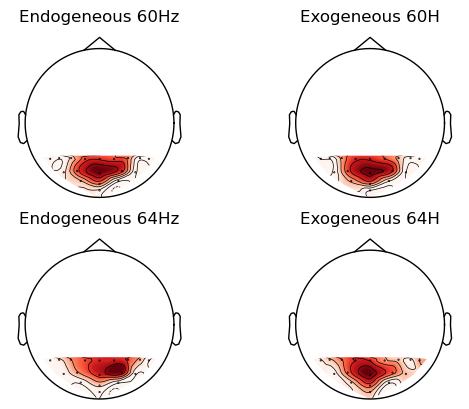

Channels with highest SNR for 60Hz endo ['POz' 'PO4' 'Pz' 'PO3' 'P1' 'P2']
Channels with highest SNR for 64Hz endo['POz' 'PO4' 'Pz' 'P1' 'PO3' 'Oz']
Channels with highest SNR for 60Hz exo ['PO4' 'POz' 'P2' 'Pz' 'P4' 'P1']
Channels with highest SNR for 64Hz exo ['POz' 'P1' 'Pz' 'Oz' 'PO3' 'PO4']


In [9]:
# plot SNR topography
fig, ax = plt.subplots(2,2)
mne.viz.plot_topomap(snrs_target1_endo, epochs.info, vlim=(1, None), axes=ax[0,0], show=False, extrapolate='local')
mne.viz.plot_topomap(snrs_target2_endo, epochs.info, vlim=(1, None), axes=ax[0,1], show=False, extrapolate='local')
mne.viz.plot_topomap(snrs_target1_exo, epochs.info, vlim=(1, None), axes=ax[1,0], show=False, extrapolate='local')
mne.viz.plot_topomap(snrs_target2_exo, epochs.info, vlim=(1, None), axes=ax[1,1], show=False, extrapolate='local')
ax[0,0].set_title('Endogeneous 60Hz')
ax[0,1].set_title('Exogeneous 60H')
ax[1,0].set_title('Endogeneous 64Hz')
ax[1,1].set_title('Exogeneous 64H')
plt.show()

# Channels with the highest SNR 
print(f'Channels with highest SNR for 60Hz endo {np.array(epochs.info['ch_names'])[np.argsort(snrs_target1_endo)[::-1]][:6]}')
print(f'Channels with highest SNR for 64Hz endo{np.array(epochs.info['ch_names'])[np.argsort(snrs_target2_endo)[::-1]][:6]}')
print(f'Channels with highest SNR for 60Hz exo {np.array(epochs.info['ch_names'])[np.argsort(snrs_target1_exo)[::-1]][:6]}')
print(f'Channels with highest SNR for 64Hz exo {np.array(epochs.info['ch_names'])[np.argsort(snrs_target2_exo)[::-1]][:6]}')
#select electrodes from 60 as the top electrodes are parietal and occipital
SNR_best_electrodes_60_endo = np.array(epochs.info['ch_names'])[np.argsort(snrs_target1_endo)[::-1]][:6]
SNR_best_electrodes_64_endo = np.array(epochs.info['ch_names'])[np.argsort(snrs_target2_endo)[::-1]][:6]
SNR_best_electrodes_60_exo = np.array(epochs.info['ch_names'])[np.argsort(snrs_target1_exo)[::-1]][:6]
SNR_best_electrodes_64_exo = np.array(epochs.info['ch_names'])[np.argsort(snrs_target2_exo)[::-1]][:6]

## 1.3 Time frequency analysis of coherence by electrode
Coherence is studied in the time window between trial start and onset of the stimuli (the post stimuli window is likely contaminated by attentional catching due to their onset).

In [10]:
# # time window from -1 sec to 1 sec relative to cue
# tmin, tmax = -1, 1
# # Define range of frequencies of interest
# freqs = np.arange(55, 75, step = 0.5)

### Magnitude squared coherence with Hilbert transform

In [11]:
# def coherence_kabir(signalX, pick, freq_of_interest):

#     #get info from EEG
#     min_time = signalX.times[0]
#     max_time = signalX.times[-1]
#     sampling_rate = signalX.info['sfreq']
    
#     # Band-pass EEG (+/-1.9Hz) and apply hilbert
#     signalX = signalX.copy().pick(pick).filter(l_freq=freq_of_interest - 1.9, h_freq=freq_of_interest + 1.9,
#         method='iir', iir_params=dict(order=4, ftype='butter'), phase='zero', fir_window='hamming', verbose = False)
#     #filter(l_freq = freq_of_interest - 1.9, h_freq = freq_of_interest + 1.9, verbose=True)
    
#     signalX = np.squeeze(signalX.get_data(copy=False)).T
#     signalXh =  scipy.signal.hilbert(signalX, axis=1)
#     n = signalXh.shape[1]  # number of trials

#     #Create sine wave
#     t = np.linspace(min_time, max_time, int(sampling_rate * (np.abs(min_time) + max_time))+1, endpoint=False)
#     signalY = np.sin(2 * np.pi * freq_of_interest * t)
#     signalY = np.tile(signalY, (n,1)).T #repeat over trials
#     # Hilbert transform
#     signalYh = scipy.signal.hilbert(signalY.T, axis=1)

#     # Magnitude
#     mX = np.abs(signalXh).T
#     mY = np.abs(signalYh)

#     # Phase difference
#     phase_diff = np.angle(signalXh).T - np.angle(signalYh)

#     coh = np.zeros(signalY.shape[0])
#     for t in range(signalY.shape[0]):
#         num = ((np.abs(np.sum(mX[:, t] * mY[:, t] * np.exp(1j * phase_diff[:, t])) / n)) ** 2)
#         denom = (np.sum((mX[:, t]**2) * (mY[:, t]**2)) / n)
#         coh[t] = num/denom
        
#     return coh

# # time window from -1 sec to 1 sec relative to cue
# tmin, tmax = -1, 1
# # Define range of frequencies of interest
# freqs = np.arange(55, 75, step = 0.5)

# channels = epochs_endo.info['ch_names']

# epochs_endo_cropped = epochs_endo.copy().crop(tmin, tmax)

# coherence_mat = np.zeros((len(channels), freqs.size, len(epochs_endo_cropped.times)))

# for e, channel in enumerate(channels):
#     for i, freq in enumerate(freqs):
#         coherence_mat[e,i,:] = coherence_kabir(epochs_endo_cropped, [channel], freq)

# coherence_hilbert = mne.time_frequency.EpochsTFRArray(epochs_endo_cropped.info, np.array([coherence_mat]), epochs_endo_cropped.times, freqs)

# # Baseline (-1 to 0s) correction
# coherence_hilbert = coherence_hilbert.apply_baseline(baseline=(tmin, 0))

# fig, axes = plt.subplots(3, 6, figsize=(18, 6))  
# axes = axes.flatten() 

# # Plot each channel
# for e, (channel, ax) in enumerate(zip(channels, axes)):
#     coherence_hilbert.plot(
#         picks=[channel],
#         baseline= None,
#         axes=ax,
#         colorbar=False,
#         show=False 
#     )
#     ax.set_title(channel)  

# plt.tight_layout()
# plt.show()



# # Channels with the highest coherence with the cued frequency
# print(f'From best to 5th \nChannels with the highest coherence with 60:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(coherence_mat[:,np.where(freqs == 60),:].max(axis = -1)))[::-1]][:6]} \
#                         \nChannels with the highest coherence with 64:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(coherence_mat[:,np.where(freqs == 64),:].max(axis = -1)))[::-1]][:6]}')
# best_electrodes_coherence_60 = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(coherence_mat[:,np.where(freqs == 60),:].max(axis = -1)))[::-1]][:6]
# best_electrodes_coherence_64 = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(coherence_mat[:,np.where(freqs == 64),:].max(axis = -1)))[::-1]][:6]

### Inter-trial coherence with multitaper estimation

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    4.1s


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


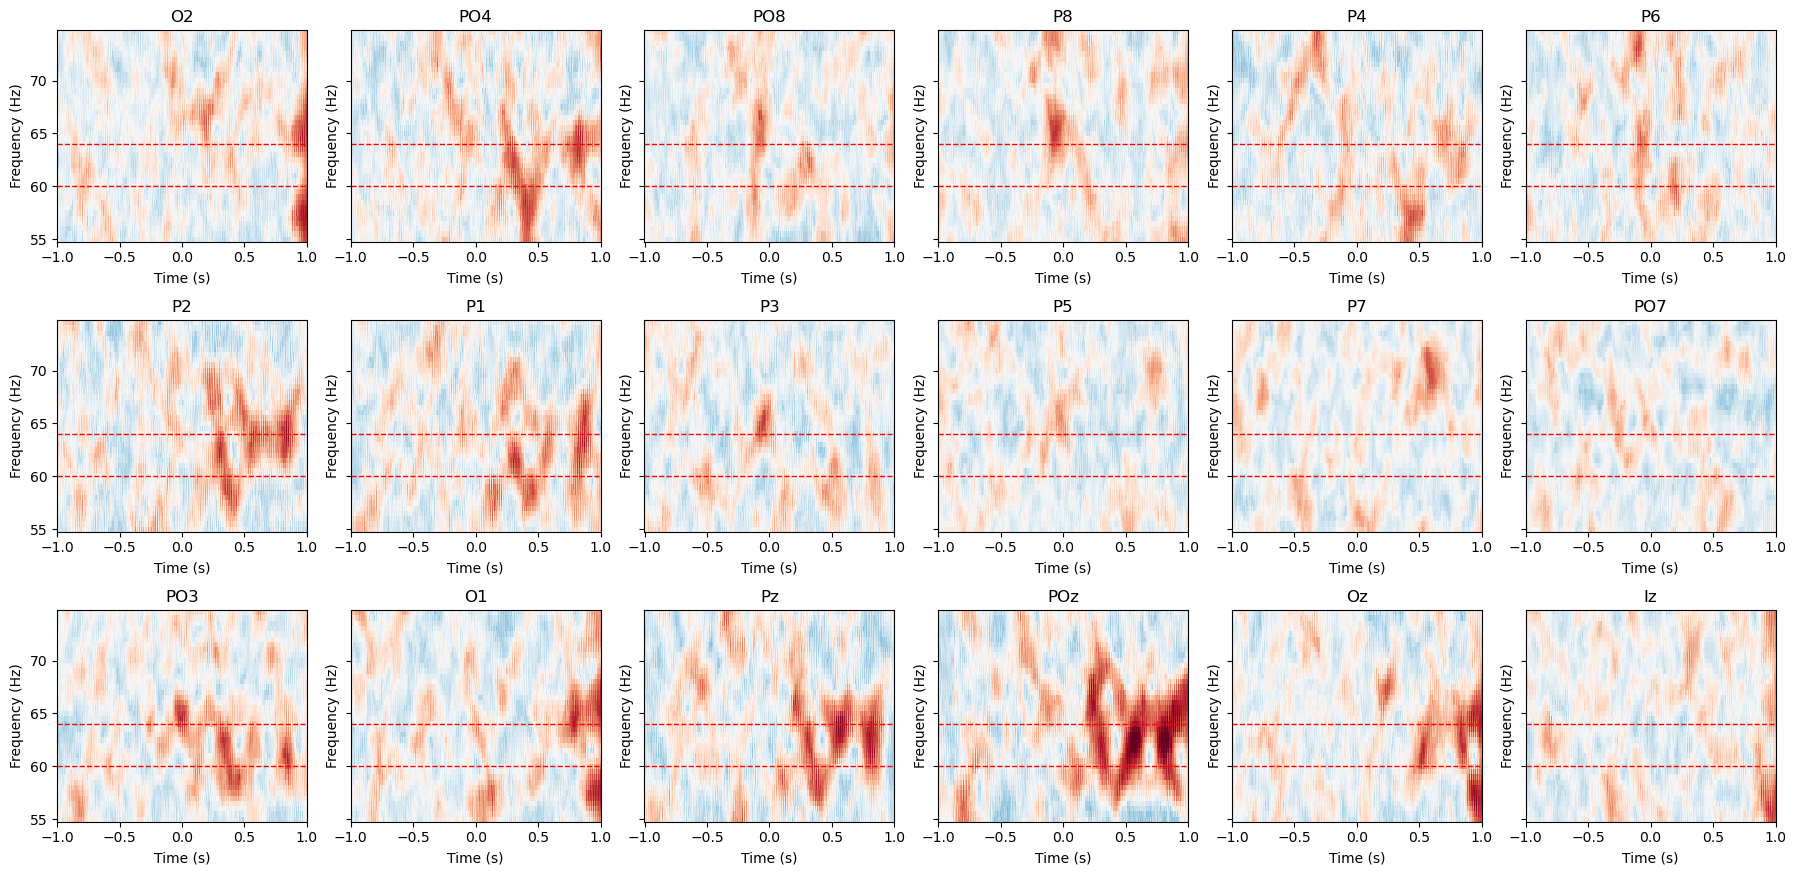

No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


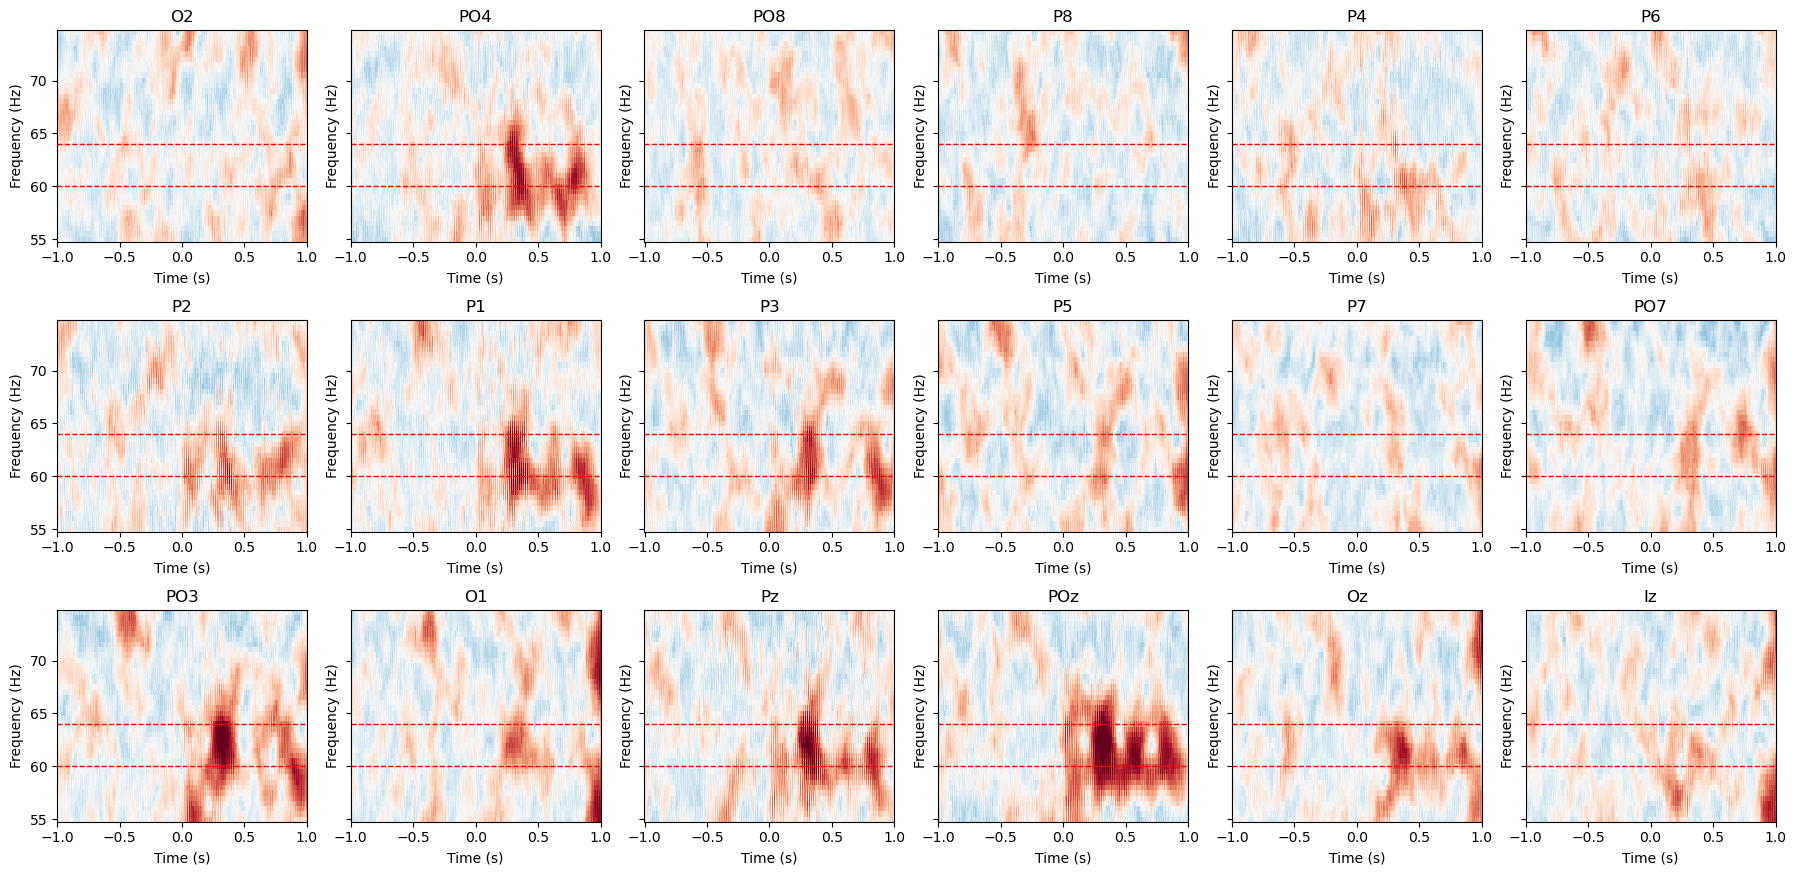

In [12]:
# n_cylce: trade-off temporal vs frequency resolution (is how many cycles of the frequency to include in the Gaussian envelope). 
# Frequency resolution is emphasized.

# time window from -1 sec to 1 sec relative to cue
tmin, tmax = -1, 1
# Define range of frequencies of interest
freqs = np.arange(55, 75, step = 0.5)

_, itc_endo = epochs_endo.copy().crop(tmin, tmax).compute_tfr(
    method="multitaper", freqs=freqs, n_cycles=freqs/4, time_bandwidth=2, return_itc=True, average=True
)
_, itc_exo = epochs_exo.copy().crop(tmin, tmax).compute_tfr(
    method="multitaper", freqs=freqs, n_cycles=freqs/4, time_bandwidth=2, return_itc=True, average=True
)

# Baseline (-1 to 0s) correction
itc_endo = itc_endo.apply_baseline(baseline=(tmin, 0))
itc_exo = itc_exo.apply_baseline(baseline=(tmin, 0))

fig, axes = plt.subplots(3, 6, figsize=(18, 9), sharey = True) 
axes = axes.flatten() 

channels = epochs.info['ch_names']

# Plot each electrode
for e, (channel, ax) in enumerate(zip(channels, axes)):
    itc_endo.plot(
        picks=[channel],
        baseline=None,
        vlim=(-.4, .4),
        axes=ax,
        colorbar=False,
        show=False 
    )
    ax.set_title(channel) 
    ax.axhline(y=60, color='r', linestyle='--', linewidth=1)
    ax.axhline(y=64, color='r', linestyle='--', linewidth=1)
    
plt.tight_layout()
plt.show()
fig, axes = plt.subplots(3, 6, figsize=(18, 9), sharey = True) 
axes = axes.flatten() 

channels = epochs.info['ch_names']

# Plot each electrode
for e, (channel, ax) in enumerate(zip(channels, axes)):
    itc_exo.plot(
        picks=[channel],
        baseline=None,
        vlim=(-.4, .4),
        axes=ax,
        colorbar=False,
        show=False 
    )
    ax.set_title(channel) 
    ax.axhline(y=60, color='r', linestyle='--', linewidth=1)
    ax.axhline(y=64, color='r', linestyle='--', linewidth=1)
    
plt.tight_layout()
plt.show()

In [13]:
# Check whether the expected frequencies are indeed the highest
itc_arr, frex_idx = itc_endo.get_data(return_freqs=True)
print(f'Frequencies in endogeneous with the maximum coherence in descending order : {frex_idx[itc_arr.mean(axis=(0,2)).argsort()[::-1]][:4]}')
print(f'From best to 6th \nChannels with the highest coherence with 64 in endo:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==60),:].max(axis = -1)))[::-1]][:6]} \
                        \nChannels with the highest coherence with 60 in endo:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==64),:].max(axis = -1)))[::-1]][:6]}')
best_electrodes_coherence_multitaper_60_endo = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==60),:].max(axis = -1)))[::-1]][:6]
best_electrodes_coherence_multitaper_64_endo = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==64),:].max(axis = -1)))[::-1]][:6]

itc_arr, frex_idx = itc_exo.get_data(return_freqs=True)
print(f'Frequencies in exogeneous with the maximum coherence in descending order : {frex_idx[itc_arr.mean(axis=(0,2)).argsort()[::-1]][:4]}')
print(f'From best to 6th \nChannels with the highest coherence with 64 in exo:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==60),:].max(axis = -1)))[::-1]][:6]} \
                        \nChannels with the highest coherence with 60 in enxxo:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==64),:].max(axis = -1)))[::-1]][:6]}')
best_electrodes_coherence_multitaper_60_exo = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==60),:].max(axis = -1)))[::-1]][:6]
best_electrodes_coherence_multitaper_64_exo = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==64),:].max(axis = -1)))[::-1]][:6]

Frequencies in endogeneous with the maximum coherence in descending order : [64.  64.5 63.5 63. ]
From best to 6th 
Channels with the highest coherence with 64 in endo:['POz' 'O1' 'PO3' 'Pz' 'O2' 'Oz']                         
Channels with the highest coherence with 60 in endo:['POz' 'Pz' 'P2' 'Oz' 'O1' 'O2']
Frequencies in exogeneous with the maximum coherence in descending order : [60.5 61.  60.  61.5]
From best to 6th 
Channels with the highest coherence with 64 in exo:['POz' 'Pz' 'P1' 'PO4' 'P3' 'P2']                         
Channels with the highest coherence with 60 in enxxo:['POz' 'Pz' 'PO4' 'PO3' 'P1' 'P3']


## 1.4 Select electrodes based on previous analysis

In [14]:
print(f'Top 6 electrodes for SNR 60 endo {SNR_best_electrodes_60_endo}')
print(f'Top 6 electrodes for SNR 64 endo {SNR_best_electrodes_64_endo}')
print(f'Top 6 electrodes for SNR 60 exo {SNR_best_electrodes_60_exo}')
print(f'Top 6 electrodes for SNR 64 exo {SNR_best_electrodes_64_exo}')
# print(f'Top 6 electrodes for Coherence 60 {best_electrodes_coherence_60}')
# print(f'Top 6 electrodes for Coherence 64 {best_electrodes_coherence_64}')
print(f'Top 6 electrodes for ITC multitaper 60 endo {best_electrodes_coherence_multitaper_60_endo}')
print(f'Top 6 electrodes for ITC multitaper 64 endo {best_electrodes_coherence_multitaper_64_endo}')

print(f'Top 6 electrodes for ITC multitaper 60 exo {best_electrodes_coherence_multitaper_60_exo}')
print(f'Top 6 electrodes for ITC multitaper 64 exo {best_electrodes_coherence_multitaper_64_exo}')

Top 6 electrodes for SNR 60 endo ['POz' 'PO4' 'Pz' 'PO3' 'P1' 'P2']
Top 6 electrodes for SNR 64 endo ['POz' 'PO4' 'Pz' 'P1' 'PO3' 'Oz']
Top 6 electrodes for SNR 60 exo ['PO4' 'POz' 'P2' 'Pz' 'P4' 'P1']
Top 6 electrodes for SNR 64 exo ['POz' 'P1' 'Pz' 'Oz' 'PO3' 'PO4']
Top 6 electrodes for ITC multitaper 60 endo ['POz' 'O1' 'PO3' 'Pz' 'O2' 'Oz']
Top 6 electrodes for ITC multitaper 64 endo ['POz' 'Pz' 'P2' 'Oz' 'O1' 'O2']
Top 6 electrodes for ITC multitaper 60 exo ['POz' 'Pz' 'P1' 'PO4' 'P3' 'P2']
Top 6 electrodes for ITC multitaper 64 exo ['POz' 'Pz' 'PO4' 'PO3' 'P1' 'P3']


In [15]:
# Select top 6 electrodes that are the most often the best according to SNR, IT coherence and MS coherence
all_electrodes = (list(SNR_best_electrodes_60_endo) + 
                  list(SNR_best_electrodes_64_endo) + 
                  list(SNR_best_electrodes_60_exo) + 
                  list(SNR_best_electrodes_64_exo) + 
                  # list(best_electrodes_coherence_60) + 
                  # list(best_electrodes_coherence_64) + 
                  list(best_electrodes_coherence_multitaper_60_endo) + 
                  list(best_electrodes_coherence_multitaper_64_endo) + 
                  list(best_electrodes_coherence_multitaper_60_exo) + 
                  list(best_electrodes_coherence_multitaper_64_exo))

# Count the occurrences of each electrode
electrode_counts = Counter(all_electrodes)

best_electrodes = [electrode for electrode, count in electrode_counts.most_common(6)]

print(f'selected electrodes: {best_electrodes}')

selected electrodes: ['POz', 'Pz', 'PO4', 'P1', 'PO3', 'P2']


# 2 - Testing for an attentional effect
### Comparing SNR across cued conditions

In [16]:
queries = ["cued_tag == 60 & attention_type_block==0", "cued_tag == 64 & attention_type_block==0",
          "cued_tag == 60 & attention_type_block==1", "cued_tag == 64 & attention_type_block==1"]
vals = {}
stim_freq1 = 60
stim_freq2 = 64

sfreq = epochs_endo.info['sfreq']
tmin = 0 # Search in window starting from cue (when SSVEP is expected)
tmax = 2
fmin = 1.0
fmax = 90.0

for query in queries:
    # Spectrum averaged over all trials
    spectrum = epochs[query].copy().pick(best_electrodes).compute_psd(
        "welch",
        n_fft=int(sfreq * (tmax - tmin)),
        n_overlap=0,
        n_per_seg=None,
        tmin=tmin,
        tmax=tmax,
        fmin=fmin,
        fmax=fmax,
        window="hamming",
        verbose=False,
    )
    psds, freqs_psd = spectrum.get_data(return_freqs=True)

    # find index of frequency bin closest to stimulation frequency
    i_bin_1 = np.argmin(abs(freqs_psd - stim_freq1))
    i_bin_2 = np.argmin(abs(freqs_psd - stim_freq2))
    
    # Apply the subset
    vals[str(int(stim_freq1))+query] = copy.deepcopy(np.mean(psds,axis=0)[:, i_bin_1])
    vals[str(int(stim_freq2))+query] = copy.deepcopy(np.mean(psds,axis=0)[:, i_bin_2])


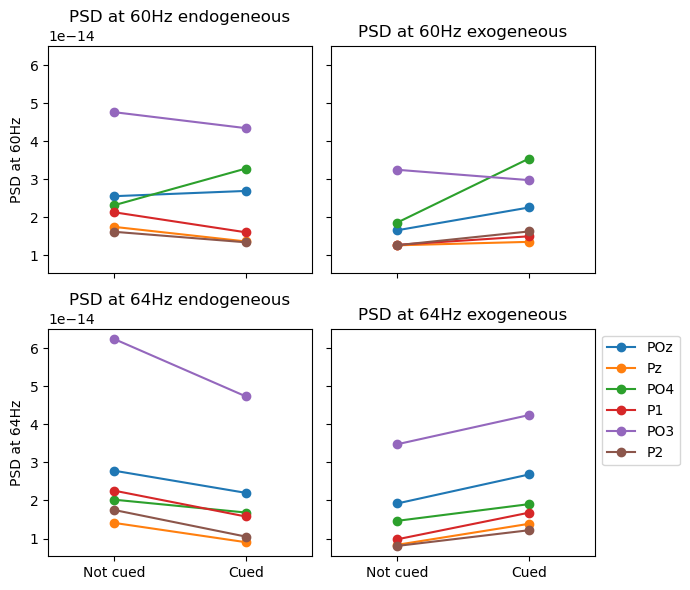

In [17]:
fig, ax = plt.subplots(2,2, figsize=(7,6), sharex=True, sharey=True)
for e, elec in enumerate(best_electrodes):
    ax[0,0].plot([0,1], [vals['60cued_tag == 64 & attention_type_block==0'][e], vals['60cued_tag == 60 & attention_type_block==0'][e]], 'o-', label=elec)
    ax[1,0].plot([0,1], [vals['64cued_tag == 60 & attention_type_block==0'][e], vals['64cued_tag == 64 & attention_type_block==0'][e]], 'o-', label=elec)
    ax[0,1].plot([0,1], [vals['60cued_tag == 64 & attention_type_block==1'][e], vals['60cued_tag == 60 & attention_type_block==1'][e]], 'o-', label=elec)
    ax[1,1].plot([0,1], [vals['64cued_tag == 60 & attention_type_block==1'][e], vals['64cued_tag == 64 & attention_type_block==1'][e]], 'o-', label=elec)

ax[0,0].set_title('PSD at 60Hz endogeneous')
ax[0,1].set_title('PSD at 60Hz exogeneous')
ax[1,0].set_title('PSD at 64Hz endogeneous')
ax[1,1].set_title('PSD at 64Hz exogeneous')
ax[0,0].set_ylabel('PSD at 60Hz')
ax[1,0].set_ylabel('PSD at 64Hz')
ax[1,0].set_xticks([0,1], ['Not cued', 'Cued'])
ax[1,1].set_xticks([0,1], ['Not cued', 'Cued'])
ax[1,1].set_xlim(-.5, 1.5)
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

In [18]:
# Normalize the frequency amplitudes as in Adamian & Andersen, 2024
npsd56 = frequency_rescaling(np.vstack([vals['60cued_tag == 60 & attention_type_block==0'],\
                                        vals['60cued_tag == 64 & attention_type_block==0'],
                                        vals['60cued_tag == 60 & attention_type_block==1'],
                                        vals['60cued_tag == 64 & attention_type_block==1'],]).T)
npsd60 = frequency_rescaling(np.vstack([vals['64cued_tag == 64 & attention_type_block==0'],\
                                        vals['64cued_tag == 60 & attention_type_block==0'],
                                        vals['64cued_tag == 64 & attention_type_block==1'],
                                        vals['64cued_tag == 60 & attention_type_block==1'],]).T)
npsds = np.concatenate([npsd56,npsd60])

# Average over electrodes
# npsds = npsds.mean(axis=0)
# np.save('files/B1_normalizes_psds.npy', npsds)

### Comparing inter-trial coherence across cued conditions

In [19]:
# time window from -1 sec to 1 sec relative to cue
tmin, tmax = -1, 1

# Get inter-trial coherence with 60 and 64Hz by cued frequency 
freqs6064 = np.array([60, 64])
_, itc_64_endo = epochs_endo['cued_tag == 64'].copy().crop(tmin, tmax).compute_tfr(
    method="multitaper", freqs=freqs6064, n_cycles=freqs6064/4, time_bandwidth=2, return_itc=True, average=True
)

_, itc_60_endo = epochs_endo['cued_tag == 60'].copy().crop(tmin, tmax).compute_tfr(
    method="multitaper", freqs=freqs6064, n_cycles=freqs6064/4, time_bandwidth=2, return_itc=True, average=True
)
_, itc_64_exo = epochs_exo['cued_tag == 64'].copy().crop(tmin, tmax).compute_tfr(
    method="multitaper", freqs=freqs6064, n_cycles=freqs6064/4, time_bandwidth=2, return_itc=True, average=True
)

_, itc_60_exo = epochs_exo['cued_tag == 60'].copy().crop(tmin, tmax).compute_tfr(
    method="multitaper", freqs=freqs6064, n_cycles=freqs6064/4, time_bandwidth=2, return_itc=True, average=True
)

elec_idx = np.where(np.isin(epochs.info['ch_names'], best_electrodes))[0]

coherence = {}
itc_64_arr, times_coh, freqs_idx = itc_64_endo.get_data(return_freqs = True, return_times = True)
itc_60_arr = itc_60_endo.get_data()
coherence['with64_for64cued_endo'] = itc_64_arr[elec_idx,1,:]
coherence['with60_for64cued_endo'] = itc_64_arr[elec_idx,0,:]
coherence['with64_for60cued_endo'] = itc_60_arr[elec_idx,1,:]
coherence['with60_for60cued_endo'] = itc_60_arr[elec_idx,0,:]
itc_64_arr, times_coh, freqs_idx = itc_64_exo.get_data(return_freqs = True, return_times = True)
itc_60_arr = itc_60_exo.get_data()
coherence['with64_for64cued_exo'] = itc_64_arr[elec_idx,1,:]
coherence['with60_for64cued_exo'] = itc_64_arr[elec_idx,0,:]
coherence['with64_for60cued_exo'] = itc_60_arr[elec_idx,1,:]
coherence['with60_for60cued_exo'] = itc_60_arr[elec_idx,0,:]

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


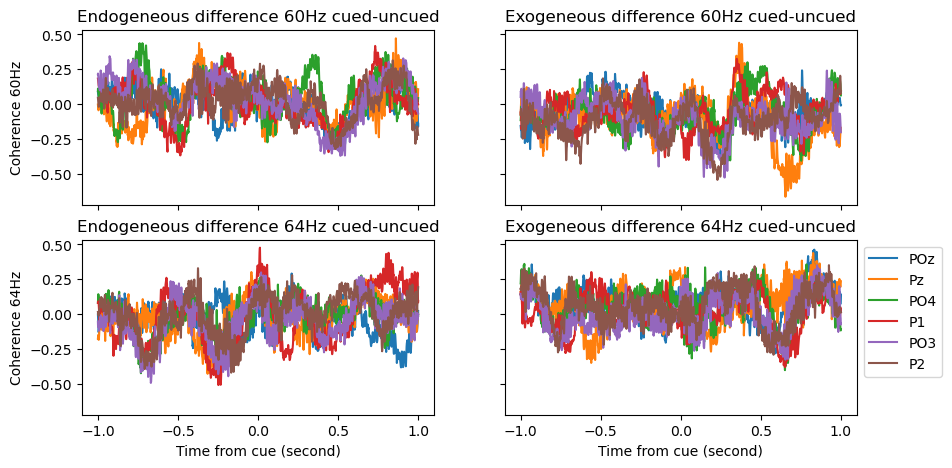

In [20]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10,5))
ax[0,0].plot(times_coh, coherence['with60_for60cued_endo'].T - coherence['with60_for64cued_endo'].T, label = best_electrodes)
ax[0,0].set_ylabel('Coherence 60Hz')
ax[0,0].set_title('Endogeneous difference 60Hz cued-uncued')
ax[1,0].plot(times_coh, coherence['with64_for64cued_endo'].T - coherence['with64_for60cued_endo'].T, label = best_electrodes)
ax[1,0].set_ylabel('Coherence 64Hz')
ax[1,0].set_title('Endogeneous difference 64Hz cued-uncued')
ax[0,1].plot(times_coh, coherence['with60_for60cued_exo'].T - coherence['with60_for64cued_exo'].T, label = best_electrodes)
ax[0,1].set_title('Exogeneous difference 60Hz cued-uncued')
ax[1,1].plot(times_coh, coherence['with64_for64cued_exo'].T - coherence['with64_for60cued_exo'].T, label = best_electrodes)
ax[1,1].set_title('Exogeneous difference 64Hz cued-uncued')

# for axi in ax.flatten():
#     axi.vlines(0, -.4, .4, color='black')

plt.legend(bbox_to_anchor=(1,1))
ax[1,0].set_xlabel('Time from cue (second)')
ax[1,1].set_xlabel('Time from cue (second)')
plt.show()


????? il semble qu il n y ait d effet attentionnel. En meme t il ne pouvait pas y avoir de target avant 1s et c etait sur car meme pas les gabor presents.

In [21]:
# Export for group analysis

def pd_coh(coherence_dic, cued, coh_with, condition):
    coherence = pd.DataFrame(coherence_dic[f'with{coh_with}_for{cued}cued_{condition}'])
    coherence['channel'] = best_electrodes
    coherence['cued'] = cued
    coherence['coh_with'] = coh_with
    coherence['condition'] = condition
    coherence = coherence.melt(id_vars=['channel','cued','coh_with','condition'])
    coherence['time'] = coherence['variable']*(1/epochs_endo.info['sfreq']) + tmin
    return coherence

coh64_cue64_endo = pd_coh(coherence, 64, 64, 'endo')
coh64_cue60_endo = pd_coh(coherence, 60, 64, 'endo')
coh60_cue64_endo = pd_coh(coherence, 64, 60, 'endo')
coh60_cue60_endo = pd_coh(coherence, 60, 60, 'endo')
coh64_cue64_exo = pd_coh(coherence, 64, 64, 'exo')
coh64_cue60_exo = pd_coh(coherence, 60, 64, 'exo')
coh60_cue64_exo = pd_coh(coherence, 64, 60, 'exo')
coh60_cue60_exo = pd_coh(coherence, 60, 60, 'exo')

ITcoh_B1 = pd.concat([coh60_cue60_endo, coh60_cue64_endo, coh64_cue60_endo, coh64_cue64_endo,
                     coh60_cue60_exo, coh60_cue64_exo, coh64_cue60_exo, coh64_cue64_exo])
ITcoh_B1.columns = ['channel', 'cued', 'coh_with', 'condition', 'timepoint', 'ITcoherence', 'time']
ITcoh_B1.to_csv('files/ITcoh_B1.csv',index=False)

### Comparing MS coherence across cued conditions

In [22]:
# # time window from -1 sec to 1 sec relative to cue
# tmin, tmax = -1, 1
# # Define range of frequencies of interest
# freqs = np.array([60, 64])

# epochs_endo_cropped = epochs_endo['cued_tag == 64'].copy().pick(best_electrodes).crop(tmin, tmax)
# coherence_mat = np.zeros((len(best_electrodes), freqs.size, len(epochs_endo_cropped.times)))
# for e, channel in enumerate(best_electrodes):
#     for i, freq in enumerate(freqs):
#         coherence_mat[e,i,:] = coherence_kabir(epochs_endo_cropped, [channel], freq)
# coherence_hilbert_64 = mne.time_frequency.EpochsTFRArray(epochs_endo_cropped.info, np.array([coherence_mat]), epochs_endo_cropped.times, freqs)

# epochs_endo_cropped = epochs_endo['cued_tag == 60'].copy().pick(best_electrodes).crop(tmin, tmax)
# coherence_mat = np.zeros((len(best_electrodes), freqs.size, len(epochs_endo_cropped.times)))
# for e, channel in enumerate(best_electrodes):
#     for i, freq in enumerate(freqs):
#         coherence_mat[e,i,:] = coherence_kabir(epochs_endo_cropped, [channel], freq)
# coherence_hilbert_60 = mne.time_frequency.EpochsTFRArray(epochs_endo_cropped.info, np.array([coherence_mat]), epochs_endo_cropped.times, freqs)

# coherence_hilbert_64, times_coh, freqs_idx = coherence_hilbert_64.get_data(return_freqs = True, return_times = True)
# coherence_hilbert_60 = coherence_hilbert_60.get_data()

In [23]:
# coherence_hilbert = {}
# coherence_hilbert['with64_for64cued'] = np.squeeze(coherence_hilbert_64)[:,1,:]
# coherence_hilbert['with60_for64cued'] = np.squeeze(coherence_hilbert_64)[:,0,:]
# coherence_hilbert['with64_for60cued'] = np.squeeze(coherence_hilbert_60)[:,1,:]
# coherence_hilbert['with60_for60cued'] = np.squeeze(coherence_hilbert_60)[:,0,:]

# plt.plot(times_coh, coherence_hilbert['with64_for64cued'].T - coherence_hilbert['with64_for60cued'].T, label = best_electrodes)
# plt.vlines(0,-0.35,0.3, color = 'black')
# plt.legend()
# plt.title('Coherence with 64Hz when 64 cued - coherence with 64 when 64 not cued')
# plt.xlabel('Time from cue')
# plt.ylabel('Coherence contrast cued/uncued')
# plt.show()

# plt.plot(times_coh, coherence_hilbert['with60_for60cued'].T - coherence_hilbert['with60_for64cued'].T, label = best_electrodes)
# plt.vlines(0,-0.35,0.3, color = 'black')
# plt.legend()
# plt.title('Coherence with 60Hz when 60 cued - coherence with 60 when 60 not cued')
# plt.xlabel('Time from cue')
# plt.ylabel('Coherence contrast cued/uncued')

In [24]:
# # Export for group analysis
# coh64_cue64 = pd_coh(coherence_hilbert, 64, 64)
# coh64_cue60 = pd_coh(coherence_hilbert, 60, 64)
# coh60_cue64 = pd_coh(coherence_hilbert, 64, 60)
# coh60_cue60 = pd_coh(coherence_hilbert, 60, 60)

# MScoh_B1 = pd.concat([coh60_cue60, coh60_cue64, coh64_cue60, coh64_cue64])
# MScoh_B1.columns = ['channel', 'cued', 'coh_with', 'timepoint', 'MScoherence', 'time']
# MScoh_B1.to_csv('files/MScoh_B1.csv',index=False)